# **Cats on a hot Tin Roof: An Overview of Categorical Encoding Methods**

## **Introduction**

The performance of a machine learning model not only depends on the model and the hyperparameters but also on how we process and feed different types of variables to the model. Since most machine learning models only accept numerical variables, preprocessing the categorical variables becomes a necessary step. We need to convert these categorical variables to numbers such that the model is able to understand and extract valuable information.


In the 1940s, Stanley Smith Stevens introduced four scales of measurement: nominal, ordinal, interval, and ratio. These are still widely used today as a way to describe the characteristics of a variable. Knowing the scale of measurement for a variable is an important aspect in choosing the right statistical analysis.
#  

![](https://lh5.googleusercontent.com/7jyxzQ2ObysJGLFcGB6Zc25AHAswexk68SbOh_KYa4if2P9yRe7lIC8NDUgZEcSGspqpRIGQcMx_qCmrG6sjHegFHy9Sqhp_1z3PFido6d19TKYFq0pMTHDs4OV9l6pP-MTNmeKu)
[image ref: What is the difference between ordinal, interval and ratio variables? Why should I care?](https://www.graphpad.com/support/faq/what-is-the-difference-between-ordinal-interval-and-ratio-variables-why-should-i-care/)

#  

Usually there are 2 kinds of categorical data:

- Ordinal Data: The categories have an inherent order
like: socio economic status (“low income”,”middle income”,”high income”), education level (“high school”,”BS”,”MS”,”PhD”), income level (“less than 50K”, “50K-100K”, “over 100K”), satisfaction rating (“extremely dislike”, “dislike”, “neutral”, “like”, “extremely like”)
- Nominal Data: The categories do not have an inherent order 
like: blood type, zip code, gender, race, ethnicity

Also binary data could be nominal or ordinal.

Generally, In Ordinal data, while encoding, one should retain the information regarding the order in which the category is provided. While encoding Nominal data, we have to consider the presence or absence of a feature. In such a case, no notion of order is present. 





So how should we select encoding methods is depends algorithm(s) we apply :
        
- Some algorithms can work with categorical data directly e.g CatBoost , or For example, a decision tree can be learned directly from categorical data with no data transform required (this depends on the specific implementation).

- Many machine learning algorithms cannot operate on label data directly. They require all input variables and output variables to be numeric.

- Some implementations of machine learning algorithms require all data to be numerical. For example, scikit-learn has this requirement.

- If we categorize algorithms to linear and tree based models we sholuld consider that generally linear models are sensitive to order of ordinal data so we should select appropriate encoding methods. 





>## **Content:**
>    
>#### 1. Quick EDA
>#### 2. Label Encoding
>#### 3. One-Hot Encoding, Dummy Encoding
>#### 4. Frequency Encoding
>#### 5. Target Encoding
>#### 6. Hash Encoding
>#### 7. Bayesian Encoding
>#### 8. CatBoost and Cats
>#### 9. LightGBM and Cats


>In this notebook we will review some encoding techniques along side with applying some algorithms and base models. All models are as base and boosting is possible by applying advanced feat eng, feat selection, model tuning and so on.



In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-feb-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-feb-2021/train.csv
/kaggle/input/tabular-playground-series-feb-2021/test.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

from scipy import stats
from scipy.stats import rankdata, norm

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR, NuSVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import *

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
import time, os, warnings, random, string, re, gc, sys

import category_encoders as ce

import lightgbm as lgb
import catboost as cb



if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    

def set_seed(seed=4242):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed()

plt.style.use('fivethirtyeight')

In [3]:
train = pd.read_csv('/kaggle/input/tabular-playground-series-feb-2021/train.csv')
test = pd.read_csv('/kaggle/input/tabular-playground-series-feb-2021/test.csv')
del train['id']
del test['id']

train.shape, test.shape

((300000, 25), (200000, 24))

## **Quick EDA**

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 25 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cat0    300000 non-null  object 
 1   cat1    300000 non-null  object 
 2   cat2    300000 non-null  object 
 3   cat3    300000 non-null  object 
 4   cat4    300000 non-null  object 
 5   cat5    300000 non-null  object 
 6   cat6    300000 non-null  object 
 7   cat7    300000 non-null  object 
 8   cat8    300000 non-null  object 
 9   cat9    300000 non-null  object 
 10  cont0   300000 non-null  float64
 11  cont1   300000 non-null  float64
 12  cont2   300000 non-null  float64
 13  cont3   300000 non-null  float64
 14  cont4   300000 non-null  float64
 15  cont5   300000 non-null  float64
 16  cont6   300000 non-null  float64
 17  cont7   300000 non-null  float64
 18  cont8   300000 non-null  float64
 19  cont9   300000 non-null  float64
 20  cont10  300000 non-null  float64
 21  cont11  30

In [5]:
cats = [c for c in train.columns if train[c].dtypes=='object']
cats

['cat0',
 'cat1',
 'cat2',
 'cat3',
 'cat4',
 'cat5',
 'cat6',
 'cat7',
 'cat8',
 'cat9']

In [6]:
nums = [
 'cont0',
 'cont1',
 'cont2',
 'cont3',
 'cont4',
 'cont5',
 'cont6',
 'cont7',
 'cont8',
 'cont9',
 'cont10',
 'cont11',
 'cont12',
 'cont13',
 ]


<AxesSubplot:xlabel='target', ylabel='Density'>

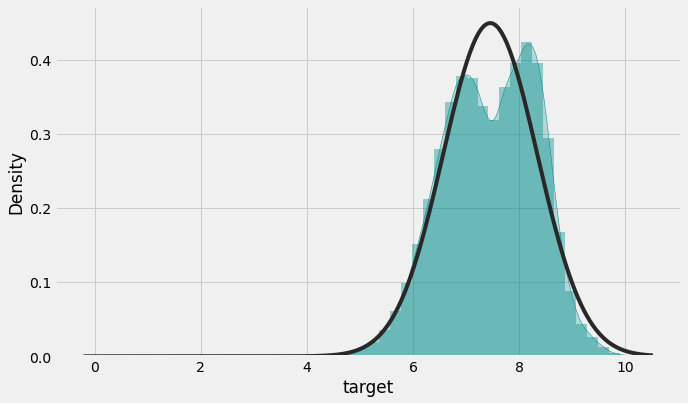

In [7]:
tr_orig = train.copy()
ts_orig = test.copy()
plt.figure(figsize=(10, 6))
sns.distplot(train.target,bins=50,  fit=norm,kde=True,kde_kws={"shade": True}, norm_hist=True,  color='darkcyan')

### Numerics

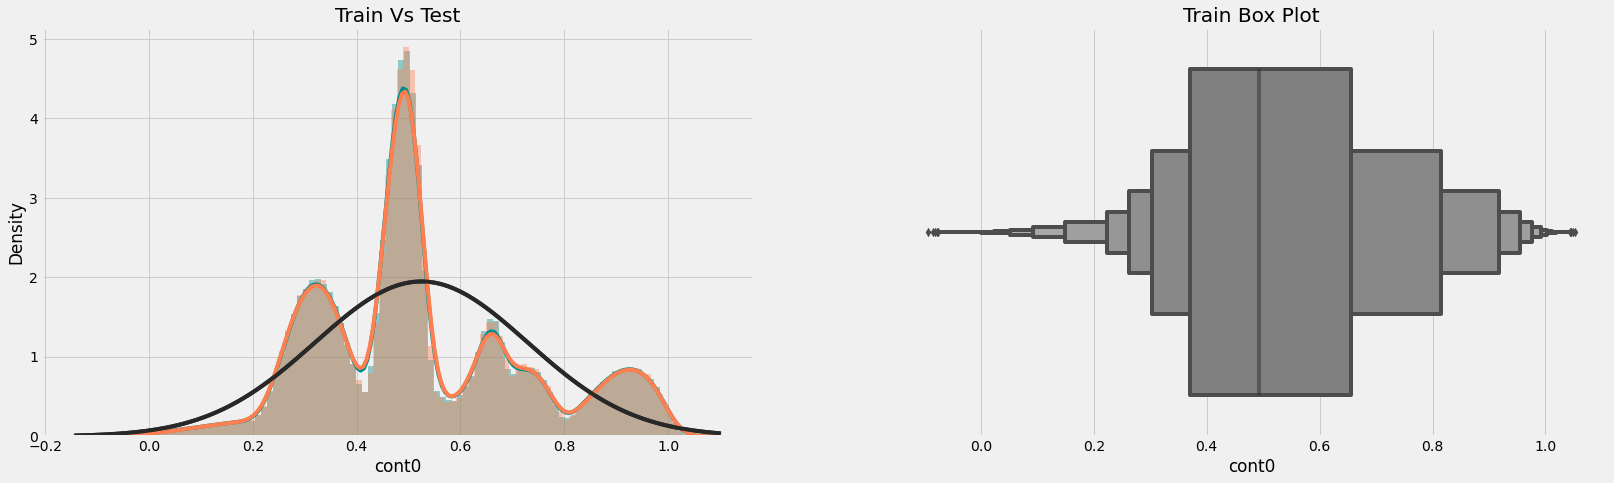

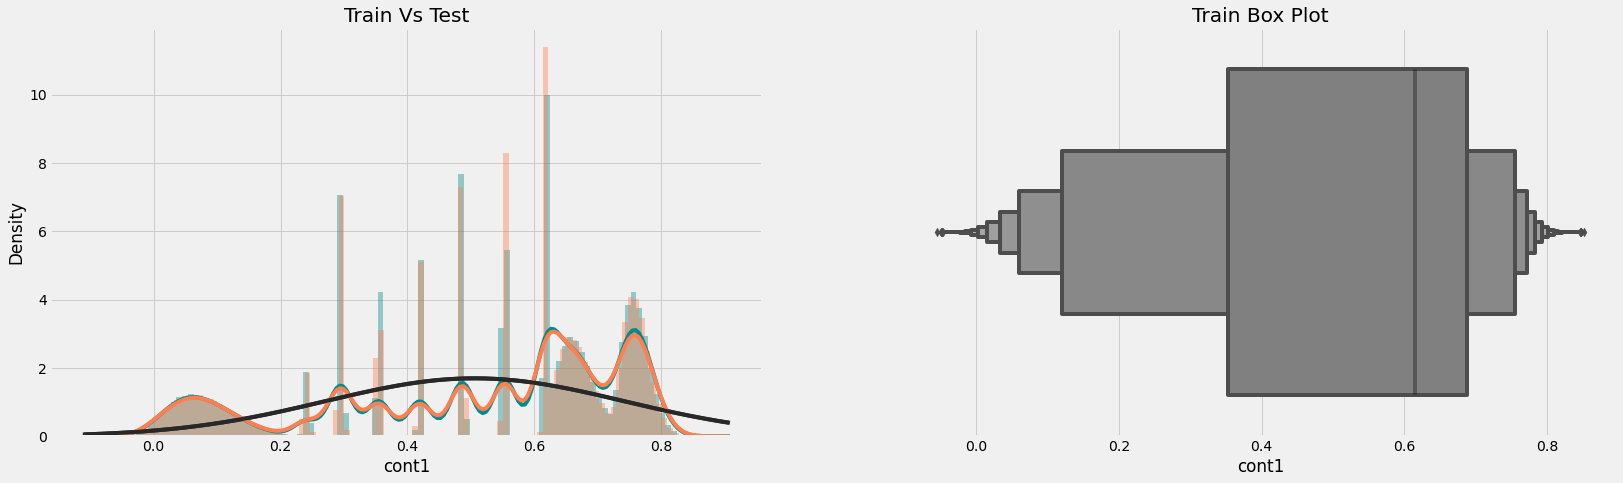

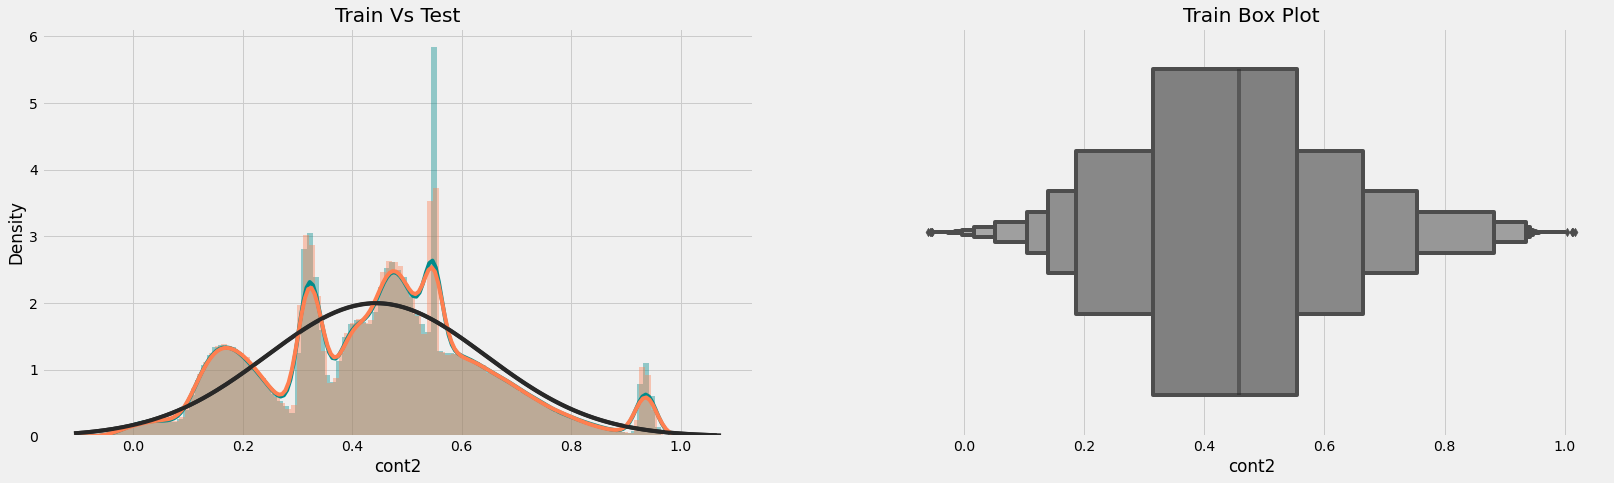

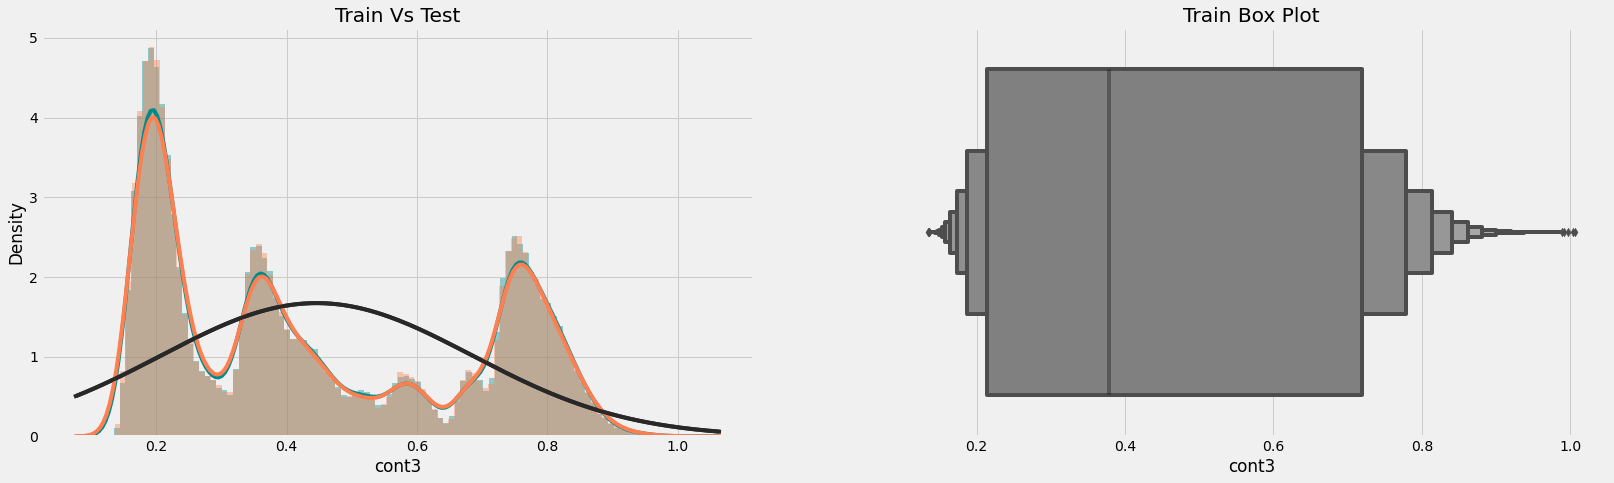

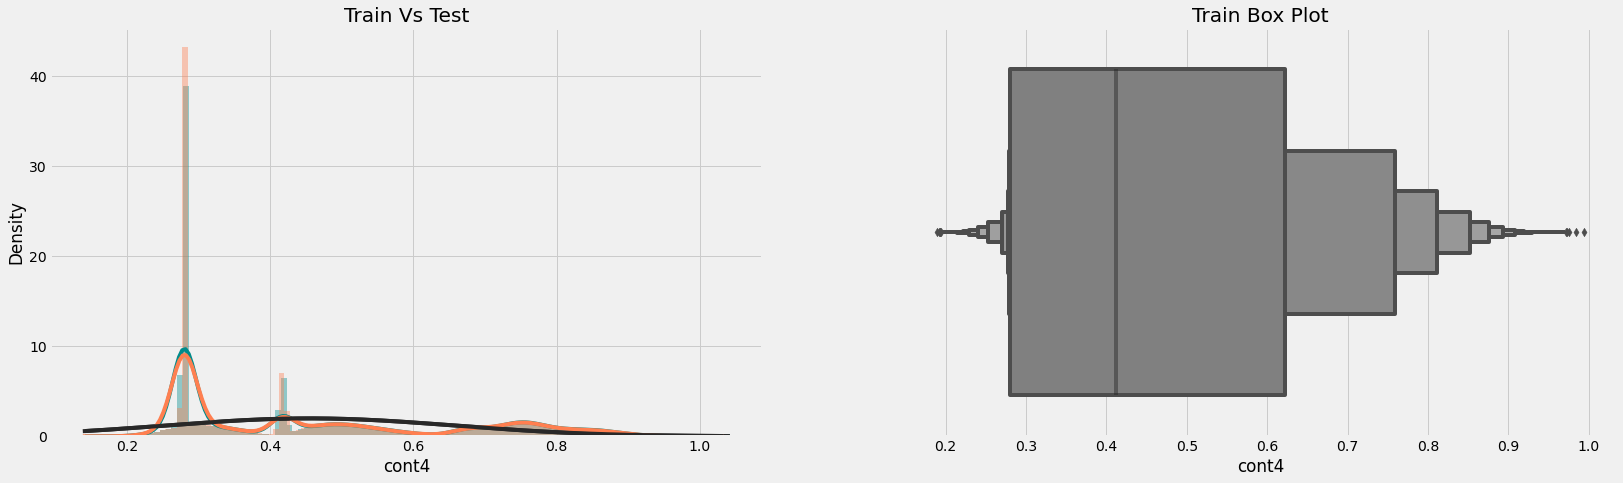

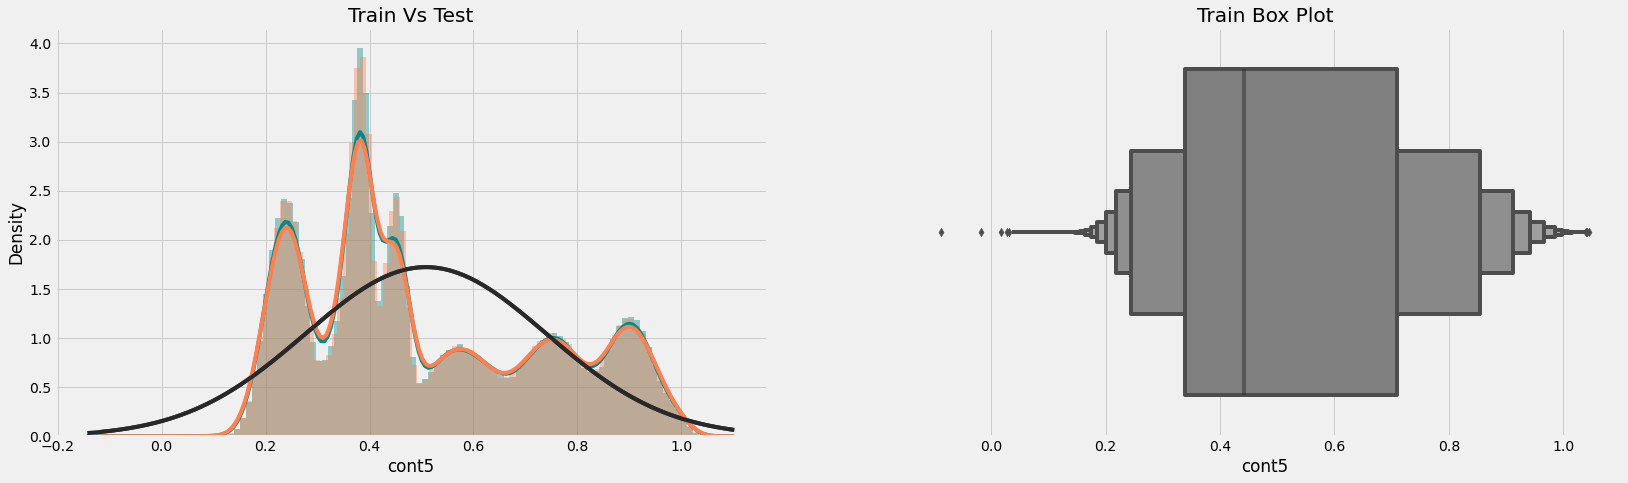

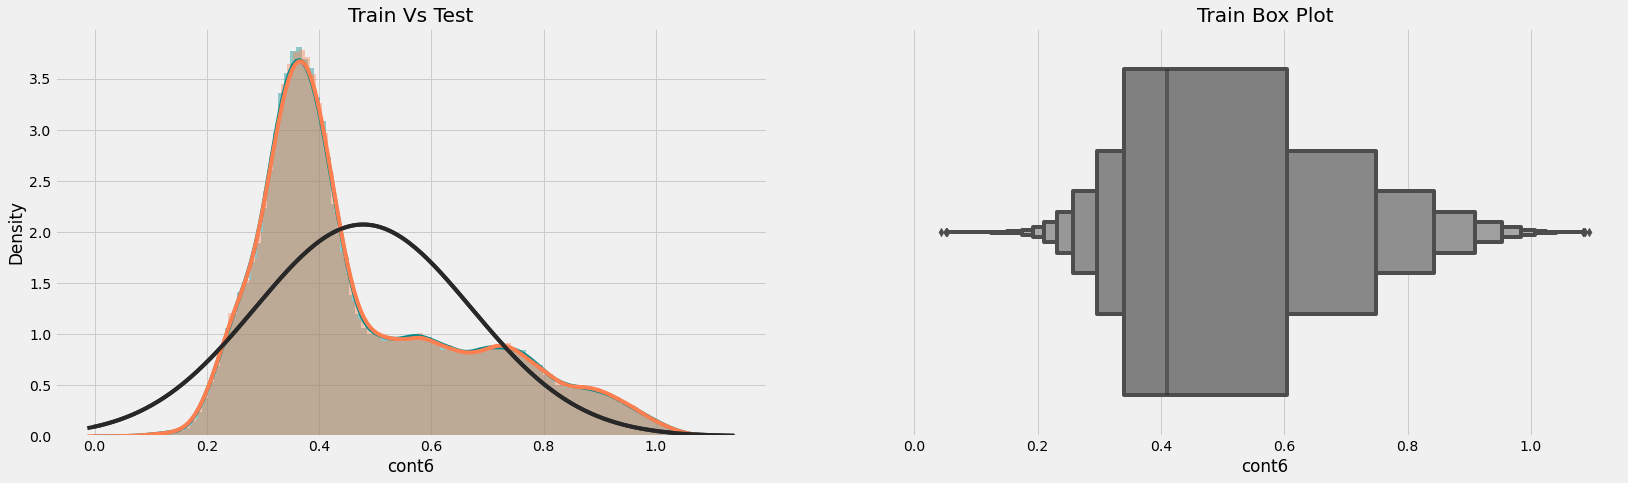

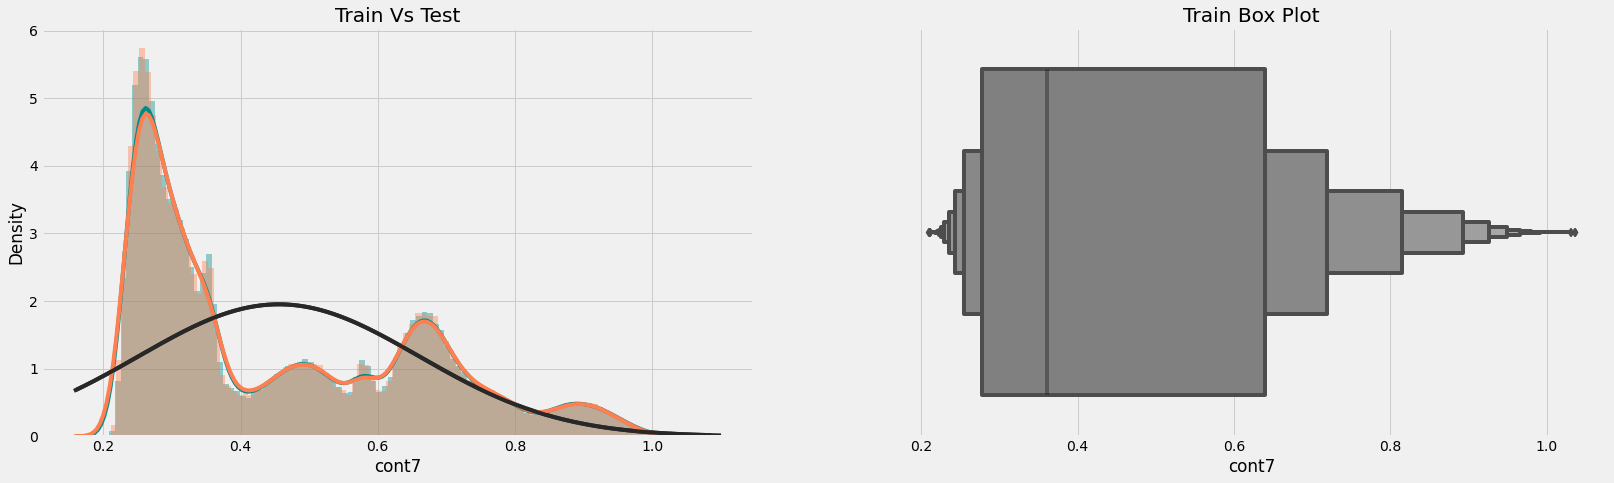

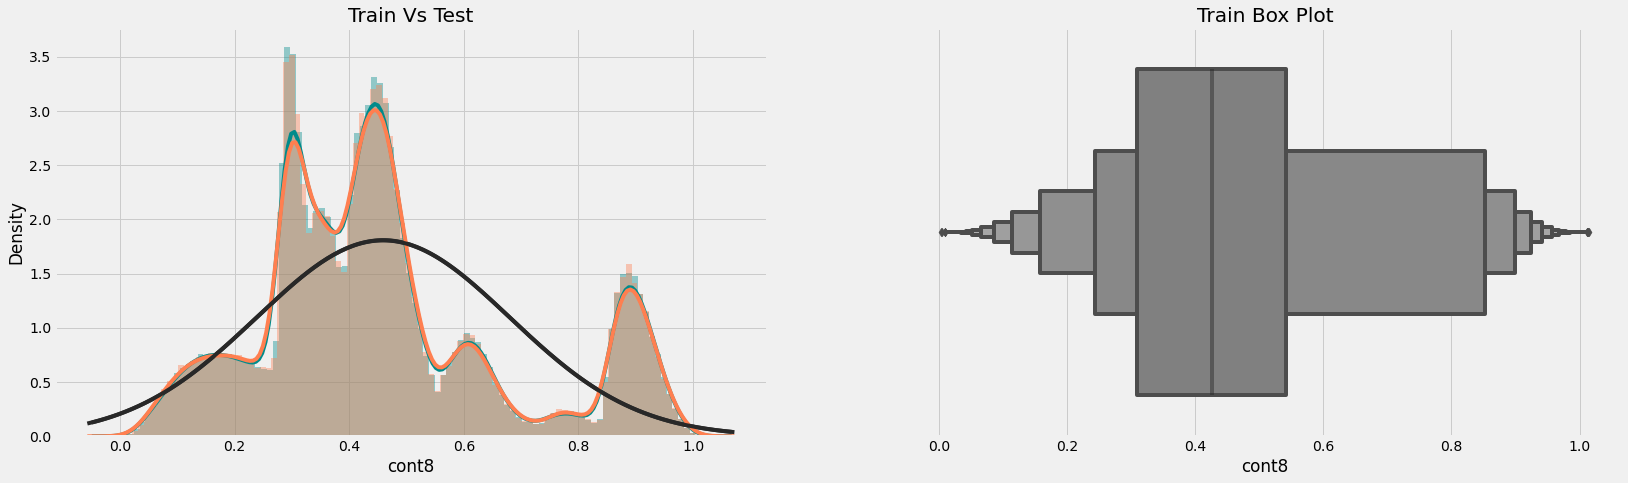

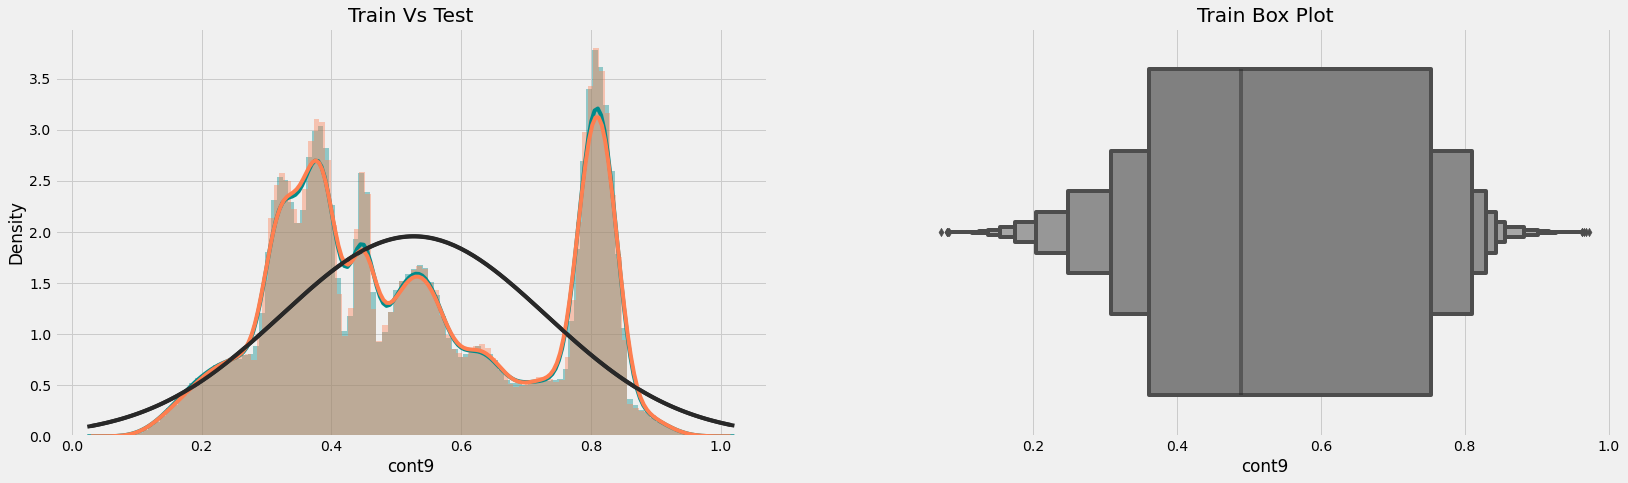

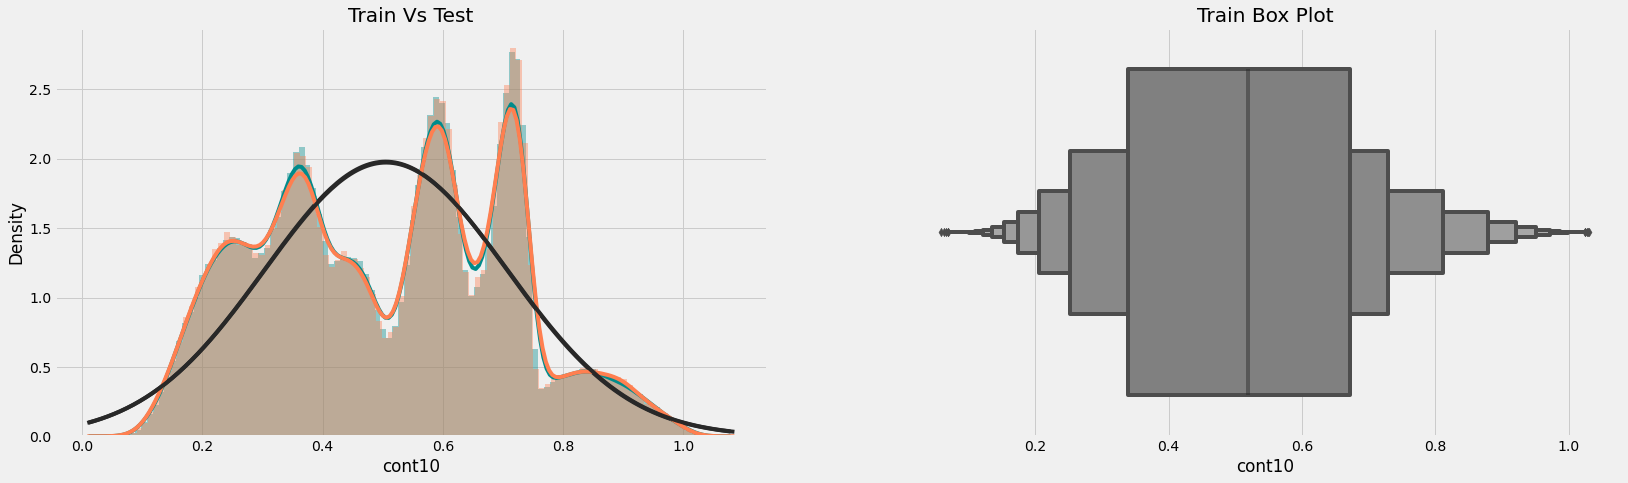

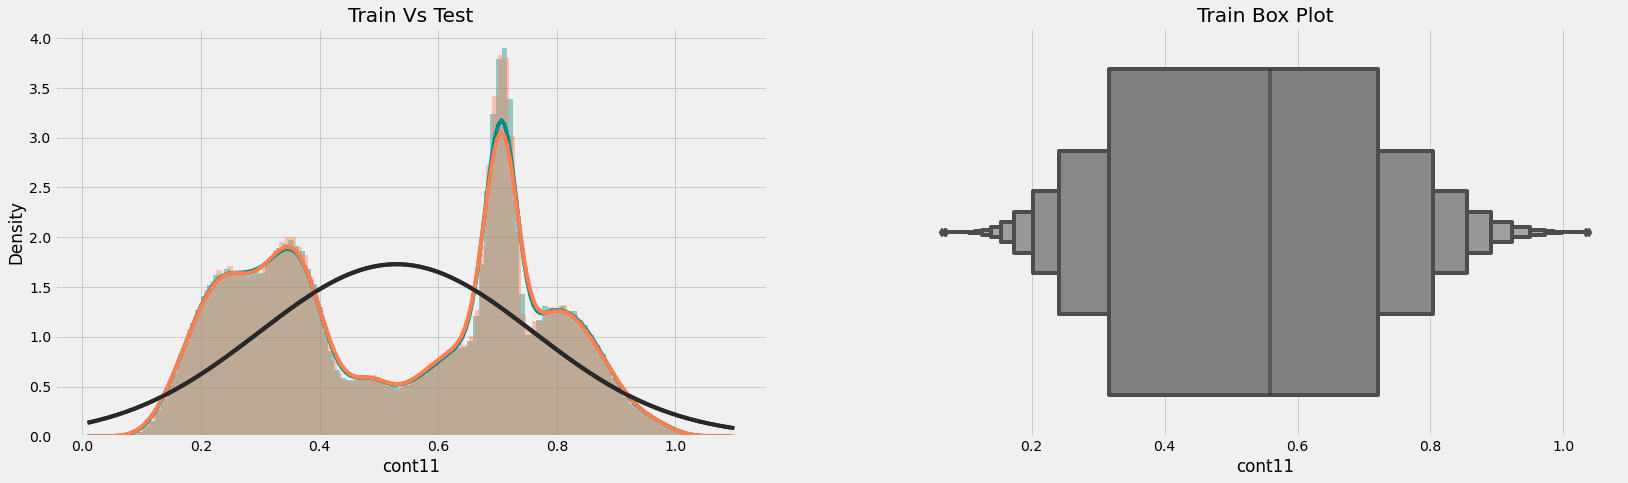

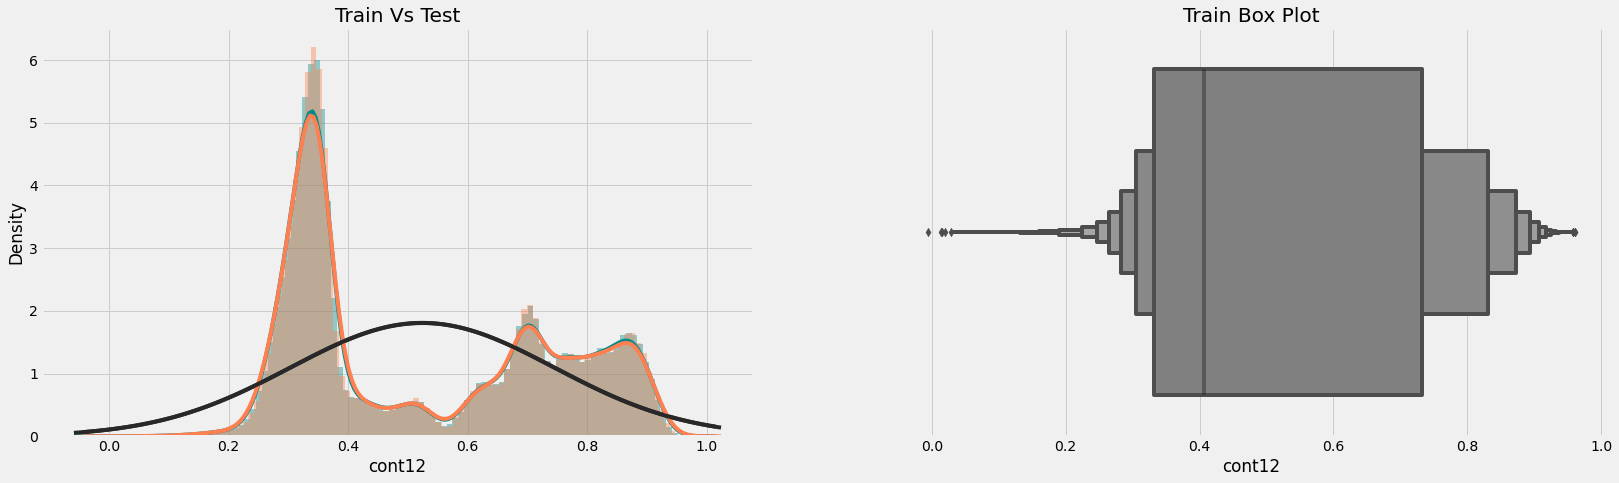

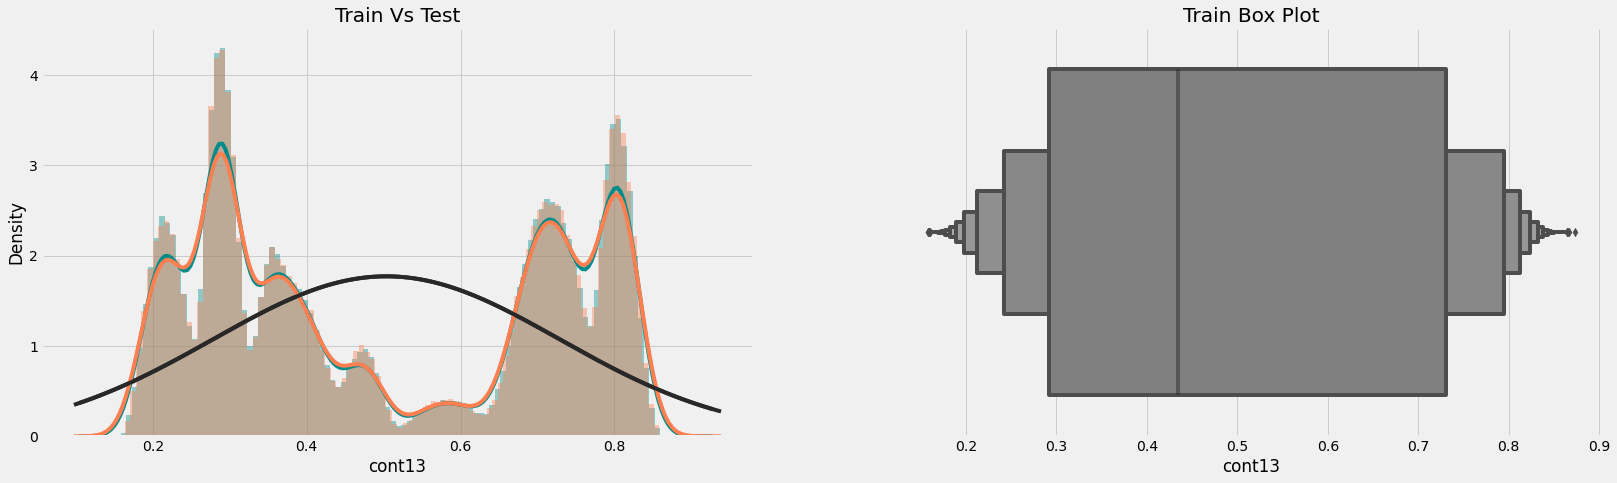

In [8]:
for c in nums:
    fig, axs = plt.subplots(ncols=2, figsize=(25, 7))
    sns.distplot(train[c],bins=100,  fit=norm, norm_hist=True,  color='darkcyan', ax=axs[0])
    sns.distplot(test[c],bins=100,  fit=norm, norm_hist=True,  color='coral', ax=axs[0])
    axs[0].set_title('Train Vs Test')
    
    sns.boxenplot(train[c], color='grey', ax=axs[1])
    axs[1].set_title('Train Box Plot')

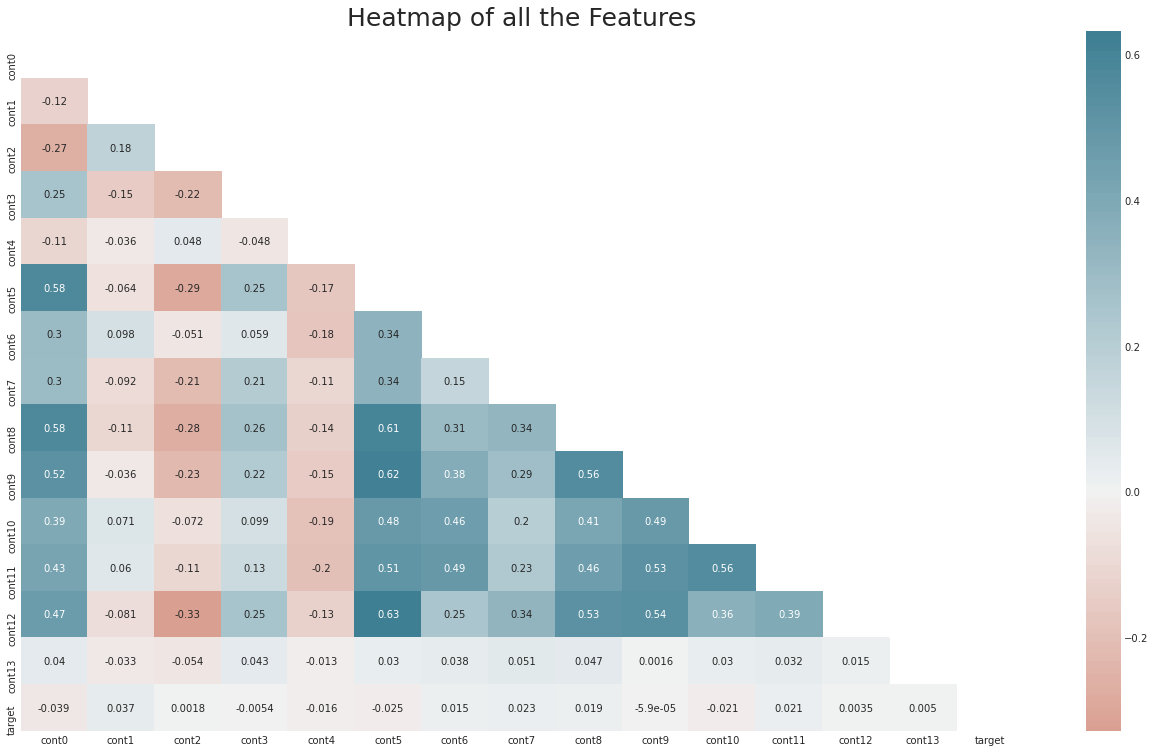

In [9]:
import matplotlib.style as style
style.use('ggplot')
sns.set_style('whitegrid')
plt.subplots(figsize = (20,12))
## Plotting heatmap. 

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(train.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


sns.heatmap(train.corr(), cmap=sns.diverging_palette(20, 220, n=200), annot=True, mask=mask, center = 0, );
## Give title. 
plt.title("Heatmap of all the Features", fontsize = 25);

### Cats

In [10]:



def analyse_cats(df, cat_cols):
    d = pd.DataFrame()
    cl = [];u = [];s =[]; nans =[]
    for c in cat_cols:
        #print("column:" , c ,"--Uniques:" , train[c].unique(), "--Cardinality:", train[c].unique().size)
        cl.append(c); u.append(df[c].unique());s.append(df[c].unique().size);nans.append(df[c].isnull().sum())
        
    d['"feat"'] = cl;d["uniques"] = u; d["cardinality"] = s; d["nans"] = nans
    return d

plt.style.use('fivethirtyeight')
catanadf = analyse_cats(train, cats)
catanadf

,"""feat""",uniques,cardinality,nans
0,cat0,"[A, B]",2,0
1,cat1,"[B, A]",2,0
2,cat2,"[A, B]",2,0
3,cat3,"[A, C, D, B]",4,0
4,cat4,"[B, C, A, D]",4,0
5,cat5,"[D, B, A, C]",4,0
6,cat6,"[A, B, D, C, E, I, G, H]",8,0
7,cat7,"[E, B, D, G, F, A, C, I]",8,0
8,cat8,"[C, A, G, E, D, F, B]",7,0
9,cat9,"[I, F, N, K, B, L, G, H, O, A, J, M, C, D, E]",15,0


## **1. Label Encoding**

Label encoding  includes replacing the categories with digits from 1 to n (or 0 to n-1, depending on the implementation),where n is the number of the variable’s distinct categories (the cardinality), and these numbers are assigned arbitrarily.

Advantages of integer (label) encoding
- Straightforward to implement.
- Does not expand the feature space.
- Can work well enough with tree-based algorithms.
- Allows agile benchmarking of machine learning models.

Limitations of integer (label) encoding
- Does not add extra information while encoding.
- Not suitable for linear models.
- Does not handle new categories in the test set automatically.
- Creates an order relationship between the categories.

Label encoding nominals:

In [11]:
for c in cats:
    le = LabelEncoder()
    le.fit(list(train[c].astype(str)) + list(test[c].astype(str)))
    train[c] = le.transform(train[c].astype(str))
    test[c] = le.transform(test[c].astype(str))
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print('target mapping :  ',c ,  le_name_mapping)

target mapping :   cat0 {'A': 0, 'B': 1}
target mapping :   cat1 {'A': 0, 'B': 1}
target mapping :   cat2 {'A': 0, 'B': 1}
target mapping :   cat3 {'A': 0, 'B': 1, 'C': 2, 'D': 3}
target mapping :   cat4 {'A': 0, 'B': 1, 'C': 2, 'D': 3}
target mapping :   cat5 {'A': 0, 'B': 1, 'C': 2, 'D': 3}
target mapping :   cat6 {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'G': 5, 'H': 6, 'I': 7}
target mapping :   cat7 {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'I': 7}
target mapping :   cat8 {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}
target mapping :   cat9 {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14}


In [12]:
target = train.pop('target')

ss = RobustScaler()
train[nums]= ss.fit_transform(train[nums])
test[nums]= ss.fit_transform(test[nums])

### **Ridge**

In [13]:
score = []

oof_rg = np.zeros(len(train))
pred_rg = np.zeros(len(test))

folds = KFold(n_splits=5, shuffle=True, random_state=42)

for fold_ , (train_ind, val_ind) in enumerate(folds.split(train, target)):
    print('fold:', fold_, '  - Starting ...')
    trn_data, val_data = train.iloc[train_ind], train.iloc[val_ind]
    y_train, y_val = target.iloc[train_ind], target.iloc[val_ind]
    
    rg = Ridge(alpha=0.1, random_state=2021)
    rg.fit(trn_data, y_train)
    oof_rg[val_ind] = rg.predict(val_data)
    y = rg.predict(trn_data)
    print('train rmse:' , np.sqrt(mean_squared_error(y_train, y)),'val rmse:' , np.sqrt(mean_squared_error(y_val, oof_rg[val_ind])))
    
    score.append(np.sqrt(mean_squared_error(y_val, oof_rg[val_ind])))
    pred_rg += rg.predict(test)/folds.n_splits
    
print('-'*50)
print(' Model rmse:  ', np.mean(score))


fold: 0   - Starting ...
train rmse: 0.8688095983872438 val rmse: 0.8692692411766098
fold: 1   - Starting ...
train rmse: 0.8687518660167458 val rmse: 0.8695079831378846
fold: 2   - Starting ...
train rmse: 0.8685873509026816 val rmse: 0.8701433565358432
fold: 3   - Starting ...
train rmse: 0.8690717050173289 val rmse: 0.8682247932752533
fold: 4   - Starting ...
train rmse: 0.8691971785877391 val rmse: 0.8677092672236159
--------------------------------------------------
 Model rmse:   0.8689709282698412


## **2. One-Hot Encoding, Dummy Encoding**

In One-Hot method, we map each category to a vector that contains 1 and 0 denoting the presence of the feature or not. The number of vectors depends on the categories which we want to keep. For high cardinality features, this method produces a lot of columns that slows down the learning significantly. There is a buzz between one hot encoding and dummy encoding and when to use one. They are much alike except one hot encoding produces the number of columns equal to the number of categories and dummy producing is one less. This should ultimately be handled by the modeler accordingly in the validation process.



![oh1](https://www.renom.jp/notebooks/tutorial/preprocessing/onehot/ConvertCategorical_en.png)

Dummy encocoding scheme is similar to one-hot encoding. This categorical data encoding method transforms the categorical variable into a set of binary variables (also known as dummy variables). In the case of one-hot encoding, for N categories in a variable, it uses N binary variables. The dummy encoding is a small improvement over one-hot-encoding. Dummy encoding uses N-1 features to represent N labels/categories.

To understand this better let’s see the image below. Here we are coding the same data using both one-hot encoding and dummy encoding techniques. While one-hot uses 3 variables to represent the data whereas dummy encoding uses 2 variables to code 3 categories.

![dum](https://cdn.analyticsvidhya.com/wp-content/uploads/2020/08/Screenshot-from-2020-08-12-18-28-24-768x452.png)

Advantages of one-hot encoding

- Does not assume the distribution of categories of the categorical variable.
- Keeps all the information of the categorical variable.
- Not so Suitable for tree based models.

Limitations of one-hot encoding
- Expands the feature space.
- Does not add extra information while encoding.
- Many dummy variables may be identical, and this can introduce redundant information.

I will use dummy encoding:

In [14]:
train = tr_orig.copy()
test = ts_orig.copy()
target = train.pop('target')
data = pd.concat([train, test], axis=0)
data = pd.get_dummies(data)
train = data.iloc[:len(train), ]
test = data.iloc[:len(test), ]



In [15]:

train.head()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,...,cat9_F,cat9_G,cat9_H,cat9_I,cat9_J,cat9_K,cat9_L,cat9_M,cat9_N,cat9_O
0,0.923191,0.684968,0.124454,0.217886,0.281421,0.881122,0.421650,0.741413,0.895799,0.802461,...,0,0,0,1,0,0,0,0,0,0
1,0.437627,0.014213,0.357438,0.846127,0.282354,0.440011,0.346230,0.278495,0.593413,0.546056,...,1,0,0,0,0,0,0,0,0,0
2,0.732209,0.760122,0.454644,0.812990,0.293756,0.914155,0.369602,0.832564,0.865620,0.825251,...,0,0,0,0,0,0,0,0,1,0
3,0.705142,0.771678,0.153735,0.732893,0.769785,0.934138,0.578930,0.407313,0.868099,0.794402,...,0,0,0,0,0,1,0,0,0,0
4,0.486063,0.639349,0.496212,0.354186,0.279105,0.382600,0.705940,0.325193,0.440967,0.462146,...,1,0,0,0,0,0,0,0,0,0


In [16]:
ss = RobustScaler()
train[nums]= ss.fit_transform(train[nums])
test[nums]= ss.fit_transform(test[nums])

In [17]:
train.shape, test.shape

((300000, 70), (200000, 70))

### **LinearSVR**

In [18]:

score = []

oof_svm = np.zeros(len(train))
pred_svm = np.zeros(len(test))

folds = KFold(n_splits=3, shuffle=True, random_state=42)

for fold_ , (train_ind, val_ind) in enumerate(folds.split(train, target)):
    print('fold:', fold_, '  - Starting ...')
    trn_data, val_data = train.iloc[train_ind], train.iloc[val_ind]
    y_train, y_val = target[train_ind], target[val_ind]
    
    lsvm =   LinearSVR(C=1, random_state=2021)
    lsvm.fit(trn_data, y_train)
    oof_svm[val_ind] = lsvm.predict(val_data)
    y = lsvm.predict(trn_data)
    print('train rmse:' , np.sqrt(mean_squared_error(y_train, y)))
    print('val rmse:' , np.sqrt(mean_squared_error(y_val, oof_svm[val_ind])))
    score.append(np.sqrt(mean_squared_error(y_val, oof_svm[val_ind])))
                           
    pred_svm += lsvm.predict(test)/folds.n_splits
    
print('-'*50)
print(' Model rmse:  ', np.mean(score))


fold: 0   - Starting ...
train rmse: 0.869208746554374
val rmse: 0.8707226520671069
fold: 1   - Starting ...
train rmse: 0.868789160659199
val rmse: 0.86917788475402
fold: 2   - Starting ...
train rmse: 0.8694229586142425
val rmse: 0.8683611275337292
--------------------------------------------------
 Model rmse:   0.8694205547849521


## **3. Frequency Encoding**

It is a way to utilize the frequency of the categories as labels. In the cases where the frequency is related somewhat with the target variable, it helps the model to understand and assign the weight in direct and inverse proportion, depending on the nature of the data.
Replace the categories by the count of the observations that show that category in the dataset. Similarly, we can replace the category by the frequency -or percentage- of observations in the dataset. 



Advantages of Count or Frequency encoding
- Straightforward to implement.
- Does not expand the feature space.
- Can work well with tree-based algorithms.

Limitations of Count or Frequency encoding

- Does not handle new categories in the test set automatically.
- We can lose valuable information if there are two different categories with the same amount of observations count—this is because we replace them with the same number.

Here we will add frequency encoded features to labeled encoded features:

In [19]:
train = tr_orig.copy()
test = ts_orig.copy()

target = train.pop('target')



In [20]:
daset = pd.concat([train, test], axis=0)


for c in (cats):
    daset[c+'_freq'] = daset[c].map(daset.groupby(c).size() / daset.shape[0])
    indexer = pd.factorize(daset[c], sort=True)[1]
    daset[c] = indexer.get_indexer(daset[c])

train= daset.iloc[:len(train) , ]
test= daset.iloc[len(train): , ]
cols=train.columns
train.shape, test.shape

((300000, 34), (200000, 34))

In [21]:
ss = StandardScaler()
train = ss.fit_transform(train)
test  = ss.transform(test)

### **Ridge**

In [22]:
score = []

oof_rg = np.zeros(len(train))
pred_rg = np.zeros(len(test))

folds = KFold(n_splits=5, shuffle=True, random_state=42)

for fold_ , (train_ind, val_ind) in enumerate(folds.split(train, target)):
    print('fold:', fold_, '  - Starting ...')
    trn_data, val_data = train[train_ind], train[val_ind]
    y_train, y_val = target.iloc[train_ind], target.iloc[val_ind]
    
    rg = Ridge(alpha=0.1, random_state=2021)
    rg.fit(trn_data, y_train)
    oof_rg[val_ind] = rg.predict(val_data)
    y = rg.predict(trn_data)
    print('train rmse:' , np.sqrt(mean_squared_error(y_train, y)),'val rmse:' , np.sqrt(mean_squared_error(y_val, oof_rg[val_ind])))
    
    score.append(np.sqrt(mean_squared_error(y_val, oof_rg[val_ind])))
    pred_rg += rg.predict(test)/folds.n_splits
    
print('-'*50)
print(' Model rmse:  ', np.mean(score))


fold: 0   - Starting ...
train rmse: 0.8669466058171931 val rmse: 0.8669048548301733
fold: 1   - Starting ...
train rmse: 0.8667430371692436 val rmse: 0.8677225787826589
fold: 2   - Starting ...
train rmse: 0.8666054510007822 val rmse: 0.8682431741538739
fold: 3   - Starting ...
train rmse: 0.8670735343520586 val rmse: 0.8663906582662209
fold: 4   - Starting ...
train rmse: 0.8672040302748487 val rmse: 0.8658517679934317
--------------------------------------------------
 Model rmse:   0.8670226068052717


Better  score in comparision with Ridge with Label Encoding

## **4. Target Encoding - Mean Likelihood Encoding ,"The Right Way !"**

Mean encoding means replacing the category with the mean target value for that category. We start by grouping each category alone, and for each group, we calculate the mean of the target in the corresponding observations. Then we assign that mean to that category. Thus, we encoded the category with the mean of the target.
Here’s a detailed illustration of mean encoding:


![te](https://miro.medium.com/max/653/1*gbKFmnAGdnaatRm011RLxA.png)




Advantages of Mean encoding

- Does not expand the feature space.
- Creates a monotonic relationship between categories and the target.

Limitations of Mean encoding
- May lead to overfitting.
- May lead to a possible loss of value if two categories have the same mean as the target—in these cases, the same number replaces the original.

According to: 
 - https://maxhalford.github.io/blog/target-encoding/
 - https://medium.com/@pouryaayria/k-fold-target-encoding-dfe9a594874b 
 
we have better implement target encoding through KFold and  with smoothing.

min_samples_leaf define a threshold where prior and target mean (for a given category value) have the same weight. Below the threshold prior becomes more important and above mean becomes more important.How weight behaves against value counts is controlled by smoothing parameter

In [23]:
train = tr_orig.copy()
test = ts_orig.copy()
target = train.pop('target')


In [24]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [25]:

smoothing =1
import category_encoders as ce
oof = pd.DataFrame([])
from sklearn.model_selection import KFold
for tr_idx, oof_idx in KFold(n_splits=5, random_state=2020, shuffle=True).split(train, target):
    ce_target_encoder = ce.TargetEncoder(cols = cats, smoothing=smoothing)
    ce_target_encoder.fit(train.iloc[tr_idx, :], target.iloc[tr_idx])
    oof = oof.append(ce_target_encoder.transform(train.iloc[oof_idx, :]), ignore_index=False)
ce_target_encoder = ce.TargetEncoder(cols = cats, smoothing=smoothing)
ce_target_encoder.fit(train, target);  train = oof.sort_index(); test = ce_target_encoder.transform(test)


In [26]:
ss = StandardScaler()
train[nums] = ss.fit_transform(train[nums])
test[nums]  = ss.transform(test[nums])

### **Ridge**

In [27]:
score = []

oof_rg = np.zeros(len(train))
pred_rg = np.zeros(len(test))

folds = KFold(n_splits=5, shuffle=True, random_state=42)

for fold_ , (train_ind, val_ind) in enumerate(folds.split(train, target)):
    print('fold:', fold_, '  - Starting ...')
    trn_data, val_data = train.iloc[train_ind], train.iloc[val_ind]
    y_train, y_val = target.iloc[train_ind], target.iloc[val_ind]
    
    rg = Ridge(alpha=0.1, random_state=2021)
    rg.fit(trn_data, y_train)
    oof_rg[val_ind] = rg.predict(val_data)
    y = rg.predict(trn_data)
    print('train rmse:' , np.sqrt(mean_squared_error(y_train, y)),'val rmse:' , np.sqrt(mean_squared_error(y_val, oof_rg[val_ind])))
    
    score.append(np.sqrt(mean_squared_error(y_val, oof_rg[val_ind])))
    pred_rg += rg.predict(test)/folds.n_splits
    
print('-'*50)
print(' Model rmse:  ', np.mean(score))


fold: 0   - Starting ...
train rmse: 0.8639634738707688 val rmse: 0.8638814982242241
fold: 1   - Starting ...
train rmse: 0.8636081856047093 val rmse: 0.8653106751805196
fold: 2   - Starting ...
train rmse: 0.8636668761944825 val rmse: 0.8650518253963407
fold: 3   - Starting ...
train rmse: 0.8641293367287941 val rmse: 0.8632165503830819
fold: 4   - Starting ...
train rmse: 0.8642635621394551 val rmse: 0.862669546173305
--------------------------------------------------
 Model rmse:   0.8640260190714942


Best result of Ridge gained with Target Encoding

### **RandomForest**

In [28]:
score = []

oof_rf = np.zeros(len(train))
pred_rf = np.zeros(len(test))

folds = KFold(n_splits=3, shuffle=True, random_state=42)

for fold_ , (train_ind, val_ind) in enumerate(folds.split(train, target)):
    print('fold:', fold_, '  - Starting ...')
    trn_data, val_data = train.iloc[train_ind], train.iloc[val_ind]
    y_train, y_val = target.iloc[train_ind], target.iloc[val_ind]
    
    rf = RandomForestRegressor(n_estimators=150,max_depth=5, n_jobs=-1,random_state=2021)
    rf.fit(trn_data, y_train)
    oof_rf[val_ind] = rf.predict(val_data)
    y = rf.predict(trn_data)
    print('train rmse:' , np.sqrt(mean_squared_error(y_train, y)),'val rmse:' , np.sqrt(mean_squared_error(y_val, oof_rf[val_ind])))
    
    score.append(np.sqrt(mean_squared_error(y_val, oof_rf[val_ind])))
    pred_rf += rf.predict(test)/folds.n_splits
    
print('-'*50)
print(' Model rmse:  ', np.mean(score))


fold: 0   - Starting ...
train rmse: 0.865817597693294 val rmse: 0.8685604037256426
fold: 1   - Starting ...
train rmse: 0.8665865948603317 val rmse: 0.8670819916921362
fold: 2   - Starting ...
train rmse: 0.8660868728415682 val rmse: 0.8668713295338873
--------------------------------------------------
 Model rmse:   0.8675045749838888


## **5. Hash Encoding**

To understand Hash encoding it is necessary to know about hashing. Hashing is the transformation of arbitrary size input in the form of a fixed-size value. We use hashing algorithms to perform hashing operations i.e to generate the hash value of an input. Further, hashing is a one-way process, in other words, one can not generate original input from the hash representation.

Hashing has several applications like data retrieval, checking data corruption, and in data encryption also. We have multiple hash functions available for example Message Digest (MD, MD2, MD5), Secure Hash Function (SHA0, SHA1, SHA2), and many more.

Just like one-hot encoding, the Hash encoder represents categorical features using the new dimensions. Here, the user can fix the number of dimensions after transformation using n_component argument. Here is what we mean – A feature with 5 categories can be represented using N new features similarly, a feature with 100 categories can also be transformed using N new features. 

By default, the Hashing encoder uses the md5 hashing algorithm but a user can pass any algorithm of his choice. 

In [29]:
train = tr_orig.copy()
test = ts_orig.copy()

target = train.pop('target')
data = pd.concat([train, test], axis=0)


using https://contrib.scikit-learn.org/category_encoders/index.html#

In [30]:
#Create object for hash encoder
encoder=ce.HashingEncoder(cols=cats,n_components=6)
data = encoder.fit_transform(data)
train = data.iloc[:len(train), ]
test = data.iloc[len(train):, ]


In [31]:
ss = StandardScaler()
train = ss.fit_transform(train)
test  = ss.transform(test)

### **Ridge**

In [32]:
score = []

oof_rg = np.zeros(len(train))
pred_rg = np.zeros(len(test))

folds = KFold(n_splits=5, shuffle=True, random_state=42)

for fold_ , (train_ind, val_ind) in enumerate(folds.split(train, target)):
    print('fold:', fold_, '  - Starting ...')
    trn_data, val_data = train[train_ind], train[val_ind]
    y_train, y_val = target.iloc[train_ind], target.iloc[val_ind]
    
    rg = Ridge()
    rg.fit(trn_data, y_train)
    oof_rg[val_ind] = rg.predict(val_data)
    y = rg.predict(trn_data)
    print('train rmse:' , np.sqrt(mean_squared_error(y_train, y)),'val rmse:' , np.sqrt(mean_squared_error(y_val, oof_rg[val_ind])))
    
    score.append(np.sqrt(mean_squared_error(y_val, oof_rg[val_ind])))
    pred_rg += rg.predict(test)/folds.n_splits
    
print('-'*50)
print(' Model rmse:  ', np.mean(score))


fold: 0   - Starting ...
train rmse: 0.8772737113318437 val rmse: 0.878163290889329
fold: 1   - Starting ...
train rmse: 0.8771316034431239 val rmse: 0.8787479590859394
fold: 2   - Starting ...
train rmse: 0.8772031871805702 val rmse: 0.8784593704832058
fold: 3   - Starting ...
train rmse: 0.8777918191311515 val rmse: 0.8760996125606801
fold: 4   - Starting ...
train rmse: 0.8777809503333096 val rmse: 0.8761519486741991
--------------------------------------------------
 Model rmse:   0.8775244363386706


Since Hashing transforms the data in lesser dimensions, it may lead to loss of information. Another issue faced by hashing encoder is the collision. Since here, a large number of features are depicted into lesser dimensions, hence multiple values can be represented by the same hash value, this is known as a collision.

Moreover, hashing encoders have been very successful in some Kaggle competitions. It is great to try if the dataset has high cardinality features.

## **6. Bayesian Target Encoding and Lightgbm**



The main motivation of Bayesian Target Encoding is to use iner-category variance in addition to the target mean in encoding categorical variables. 
The main insight is that we should compute mean, variance and higher moments of the posterior distribution.
In Bayesian learning the parameters of the distribution are themselves considered random variables. The distribution of parameters before seeing any data is called prior distribution. This distribution is updated based on the new data to become a posterior distribution. The prediction on the unseen data can be derived by marginalizing over the parameter space. To avoid intractable integrals, Bayesian practitioners often use Conjugate Priors. The beauty of them is that they have very simple update rules, that makes it possible to quickly compute posterior distribution based on the training examples.

More information:
https://towardsdatascience.com/target-encoding-and-bayesian-target-encoding-5c6a6c58ae8c

In [33]:
import gc
import numpy as np 
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
    
class BetaEncoder(object):
        
    def __init__(self, group):
        
        self.group = group
        self.stats = None
        
    # get counts from df
    def fit(self, df, target_col):
        self.prior_mean = np.mean(df[target_col])
        stats = df[[target_col, self.group]].groupby(self.group)
        stats = stats.agg(['sum', 'count'])[target_col]    
        stats.rename(columns={'sum': 'n', 'count': 'N'}, inplace=True)
        stats.reset_index(level=0, inplace=True)           
        self.stats = stats
        
    # extract posterior statistics
    def transform(self, df, stat_type, N_min=1):
        
        df_stats = pd.merge(df[[self.group]], self.stats, how='left')
        n = df_stats['n'].copy()
        N = df_stats['N'].copy()
        
        # fill in missing
        nan_indexs = np.isnan(n)
        n[nan_indexs] = self.prior_mean
        N[nan_indexs] = 1.0
        
        # prior parameters
        N_prior = np.maximum(N_min-N, 0)
        alpha_prior = self.prior_mean*N_prior
        beta_prior = (1-self.prior_mean)*N_prior
        
        # posterior parameters
        alpha = alpha_prior + n
        beta =  beta_prior + N-n
        
        # calculate statistics
        if stat_type=='mean':
            num = alpha
            dem = alpha+beta
                    
        elif stat_type=='mode':
            num = alpha-1
            dem = alpha+beta-2
            
        elif stat_type=='median':
            num = alpha-1/3
            dem = alpha+beta-2/3
        
        elif stat_type=='var':
            num = alpha*beta
            dem = (alpha+beta)**2*(alpha+beta+1)
                    
        elif stat_type=='skewness':
            num = 2*(beta-alpha)*np.sqrt(alpha+beta+1)
            dem = (alpha+beta+2)*np.sqrt(alpha*beta)

        elif stat_type=='kurtosis':
            num = 6*(alpha-beta)**2*(alpha+beta+1) - alpha*beta*(alpha+beta+2)
            dem = alpha*beta*(alpha+beta+2)*(alpha+beta+3)

        else:
            num = self.prior_mean
            dem = np.ones_like(N_prior)
            
        # replace missing
        value = num/dem
        value[np.isnan(value)] = np.nanmedian(value)
        return value
        



cat_cols = cats
train = tr_orig.copy()
test = ts_orig.copy()

lgb_params = {
    'learning_rate': 0.02,
    'application': 'regression',
    
    'num_leaves': 10,
    'verbosity': -1,
    'metric': 'rmse',
    'data_random_seed': 3,
    'bagging_fraction': 0.7,
    'feature_fraction': 0.5,
    'bagging_frequency': 1,
    'lambda_l1': 1,
    'lambda_l2': 1,
   # 'min_data_in_leaf': 40,
}

n_folds = 5
n_rounds = 400

for N_min in [10, 100, 1000, 10000, -1]: 

    print('label encoding')
    for col in cat_cols:
        le = LabelEncoder()
        le.fit(np.concatenate([train[col], test[col]]))
        train[col] = le.transform(train[col])
        test[col] = le.transform(test[col])
        
            
    scores = []
    cbe_lgb_pred = np.zeros(len(test))
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=0)
    for i, (dev_index, val_index) in enumerate(kf.split(train.index.values)):
        
        print(f'Fold {i}:')
        
        # split data
        dev = train.loc[dev_index].reset_index(drop=True)
        val = train.loc[val_index].reset_index(drop=True)
    
        # built-in categorical encoding
        if N_min==-1: 
            
            feature_cols = cat_cols
            
            # setup lightgbm data
            d_dev = lgb.Dataset(dev[cat_cols],
                                label=dev.target,
                                feature_name=cat_cols,
                                categorical_feature=cat_cols)
            d_val = lgb.Dataset(val[cat_cols],
                                label=val.target,
                                feature_name=cat_cols,
                                categorical_feature=cat_cols)
    
        # target encoding
        else: 
            
            # encode variables
            feature_cols = []
            for var_name in cat_cols:
        
                # fit encoder
                be = BetaEncoder(var_name)
                be.fit(dev, 'target')
        
                # mean
                feature_name = f'{var_name}_mean'
                dev[feature_name]  = be.transform(dev,  'mean', N_min)
                val[feature_name]  = be.transform(val,  'mean', N_min)
                test[feature_name] = be.transform(test, 'mean', N_min)        
                feature_cols.append(feature_name)
                
            # setup lightgbm data
            d_dev = lgb.Dataset(dev[feature_cols], label=dev.target)
            d_val = lgb.Dataset(val[feature_cols], label=val.target)
        
        # fit model
        mdl = lgb.train(lgb_params,
                          train_set = d_dev,
                          num_boost_round = n_rounds,
                          valid_sets = [d_dev, d_val],
                          verbose_eval = n_rounds//5)
        scores.append(mdl.best_score['valid_1']['rmse'])
        
        # make predictions on test set
        cbe_lgb_pred += mdl.predict(test[feature_cols])/n_folds    
        
    # clean up
    del d_dev, d_val, mdl
    gc.collect()
    
    # print results
    if N_min==-1:
        print(f'baseline: {np.mean(scores):0.2f}')
    else: 
        print(f'N_min={N_min}: {np.mean(scores):0.2f}')
        
    # save data
    #subm['deal_probability'] = np.clip(subm['deal_probability'], 0, 1)
    #if N_min==-1:
    #    subm.to_csv(f'submission-baseline.csv', index=False)
    #else: 
    #    subm.to_csv(f'submission-{N_min}.csv', index=False)

label encoding
Fold 0:
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[80]	training's rmse: 0.872075	valid_1's rmse: 0.871441
[160]	training's rmse: 0.869163	valid_1's rmse: 0.868857
[240]	training's rmse: 0.868475	valid_1's rmse: 0.868369
[320]	training's rmse: 0.868233	valid_1's rmse: 0.868262
[400]	training's rmse: 0.868099	valid_1's rmse: 0.868236
Fold 1:
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[80]	training's rmse: 0.87238	valid_1's rmse: 0.870527
[160]	training's rmse: 0.869526	valid_1's rmse: 0.8677
[240]	training's rmse: 0.868866	valid_1's rmse: 0.867066
[320]	training's rmse: 0.868632	valid_1's rmse: 0.866883
[400]	training's rmse: 0.868501	valid_1's rmse: 0.866819
Fold 2:
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[80]	training's rmse: 0.871626	valid_1's rmse: 0.873253
[160]	training's rmse: 0.868701	valid_1's rmse: 0.870694
[240]	training's rmse: 0.86801	valid_1's rmse: 0.870265
[320]	training's rmse: 0.867768	valid_1's rmse: 0.870

## **7. CatBoost and Cats**

When running machine learning algorithms, simply assigning numbers to categorical variables work if a category has only two levels. This is the case for gender (male/female), bought a product (yes/no), attended a course (yes/no). When a category has several levels, as with nationality, assigning numbers to each level implies an order of the levels. This means that one level of the category has a lower rank than another level. While this makes sense for ordinal variables (e.g., preferences of food items or educational degree), it is a wrong assumption for nominal variables such as color preferences, nationality, residential city specially when we use linear Algorithms. Algorithms like CatBoost have different perspective to solve this problem.  

We can use CatBoost without any explicit pre-processing to convert categories into numbers. CatBoost converts categorical values into numbers using various statistics on combinations of categorical features and combinations of categorical and numerical features.

In detail , Catboost calculates for every category of a nominal variable , a value (target-based statistic). This is done using a number of steps:
We begin with one categorical feature (e.g., Nationality). This is called x.
In one randomly chosen row (k-th row in the training data set), we exchange one random level of this categorical feature (i-th level of x) with a number (e.g., Dutch by 5)
This number (in our example 5) is usually based on the target variable (the one we want to predict) conditional on the category level. In other words, the target number is based on the expected outcome variable.
A splitting attribute is used to create two sets of the training data: One set that has all categories (e.g., German, French, Indian etc) who will have greater target variable than the one computed in step 3, and the other set with smaller target variables.

![catb](https://developer-blogs.nvidia.com/wp-content/uploads/2018/12/catboost_hero.png)

In their [paper](http://learningsys.org/nips17/assets/papers/paper_11.pdf) authors describe how catboost is dealing with categorical features. The standard way is to compute some statistics, such as median, based on the label values of the category. However, this creates problems if there is only one example for a label value. In this case, the numerical value of the category would be the same than the label value. For example if in our example with nationalities, the category Belgian is assigned the value 2, and there is only 1 Belgian student, this student would get the value 2 for nationality. This can create problems of overfitting.

To avoid this problem, the authors designed a solution which involves randomly changing the order of rows in the complete data set. We perform a random permutation of the data set and for each example we compute average label value for the example with the same category value placed before the given one in the permutation .In their paper they also describe how different features are combined to create a new feature. Think about it, every individual observations of categorical and numerical data points describe one observation. The chances that two observations are exactly identical is slim. Hence, different categorical values and numerical values could be combined to create a unique merged categorical variable which contains all the different individual choices. While this might sound easy, doing this for all potential types of combinations will be computational intensive.
Another way to combine different features is to do a greedy search at every tree split. Catboost does this by combining all categorical and numerical values at the current tree with all categorical values in the data set.

Transforming categorical features to numerical features methods are:


- Borders
- Buckets
- BinarizedTargetMeanValue
- Counter


 You can read more about it [here](https://catboost.ai/docs/concepts/algorithm-main-stages_cat-to-numberic.html).

In [34]:
train = tr_orig.copy()
test = ts_orig.copy()

target = train.pop('target')
categorical_features_indices = np.where(train.dtypes == 'object')[0]
categorical_features_indices

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [35]:

cat_score = []
# Split data with kfold
kfolds = KFold(n_splits=3, shuffle=True, random_state=2018)
train_features = train.columns
# Make importance dataframe
importances = pd.DataFrame()

oof_preds = np.zeros(train.shape[0])
sub_preds = np.zeros(test.shape[0])

for n_fold, (trn_idx, val_idx) in enumerate(kfolds.split(train, target)):
    X_train, y_train = train.iloc[trn_idx], target.iloc[trn_idx]
    X_valid, y_valid = train.iloc[val_idx], target.iloc[val_idx]
    
    # CatBoost Regressor estimator
    model = cb.CatBoostRegressor(
        learning_rate = 0.1,
        iterations = 2000,
        eval_metric = 'RMSE',
        allow_writing_files = False,
        od_type = 'Iter',
        bagging_temperature = 0.8,
        depth = 6,
        od_wait = 20,
        silent = False
    )
    
    # Fit
    model.fit(
        X_train, y_train,
        cat_features=categorical_features_indices,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        verbose=100,
        early_stopping_rounds=100
    )
    
    # Feature importance
    imp_df = pd.DataFrame()
    imp_df['feature'] = train_features
    imp_df['gain'] = model.get_feature_importance()
    imp_df['fold'] = n_fold + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
    oof_preds[val_idx] = model.predict(X_valid)
    cat_score.append(np.sqrt(mean_squared_error(y_valid, oof_preds[val_idx])))
    test_preds = model.predict(test)
    sub_preds += test_preds / kfolds.n_splits
    
print(np.mean(cat_score))


0:	learn: 0.8849881	test: 0.8849881	test1: 0.8823874	best: 0.8823874 (0)	total: 413ms	remaining: 13m 44s
100:	learn: 0.8486356	test: 0.8484235	test1: 0.8498500	best: 0.8498500 (100)	total: 24.1s	remaining: 7m 32s
200:	learn: 0.8419633	test: 0.8418186	test1: 0.8462056	best: 0.8462056 (200)	total: 49.7s	remaining: 7m 25s
300:	learn: 0.8375538	test: 0.8375146	test1: 0.8448569	best: 0.8448569 (300)	total: 1m 15s	remaining: 7m 5s
400:	learn: 0.8342065	test: 0.8342950	test1: 0.8441735	best: 0.8441735 (400)	total: 1m 40s	remaining: 6m 39s
500:	learn: 0.8311418	test: 0.8313577	test1: 0.8438535	best: 0.8438528 (497)	total: 2m 5s	remaining: 6m 15s
600:	learn: 0.8284913	test: 0.8288935	test1: 0.8436665	best: 0.8436654 (599)	total: 2m 29s	remaining: 5m 47s
700:	learn: 0.8260389	test: 0.8266166	test1: 0.8436769	best: 0.8436369 (630)	total: 2m 54s	remaining: 5m 22s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8436368725
bestIteration = 630

Shrink model to first 631 iteration

<AxesSubplot:xlabel='gain_log', ylabel='feature'>

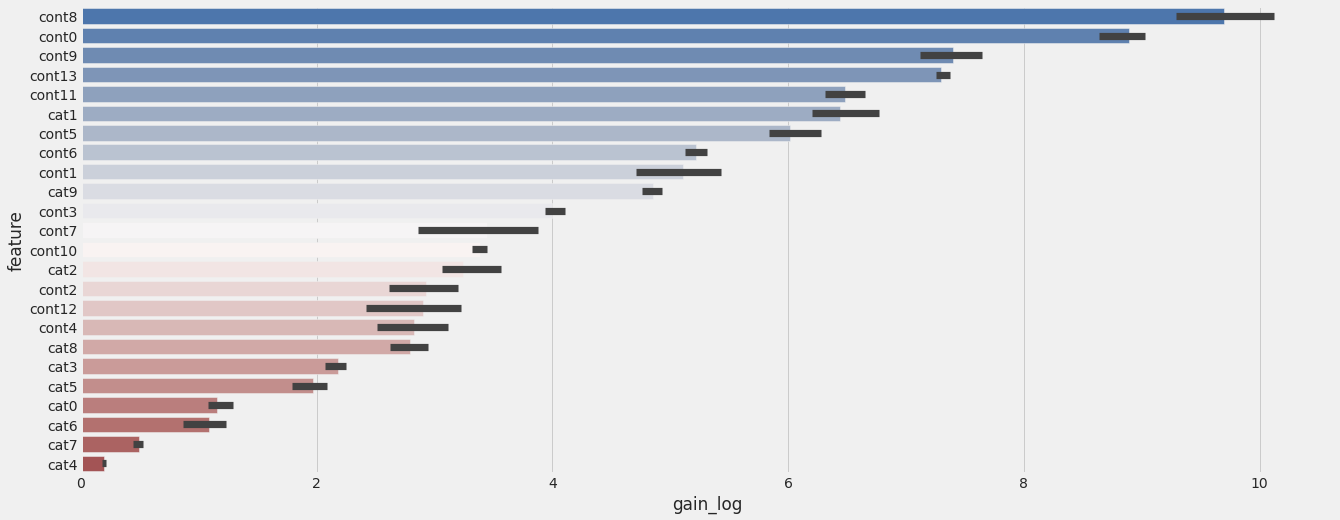

In [36]:
importances['gain_log'] = importances['gain']
mean_gain = importances[['gain', 'feature']].groupby('feature').mean()
importances['mean_gain'] = importances['feature'].map(mean_gain['gain'])

plt.figure(figsize=(20, 8))
sns.barplot(x='gain_log', y='feature', data=importances.sort_values('mean_gain', ascending=False), palette='vlag')

## **8. LightGBM and Cats**

Lgb sorts the categories according to the training objective at each split. More specifically, LightGBM sorts the histogram (for a categorical feature) according to its accumulated values (sum_gradient / sum_hessian) and then finds the best split on the sorted histogram. So the split can be made based on the variable being of one specific level or any subset of levels, so you have 2^N splits available in comparision with e.g of 4 for OHE.

The algorithm behind above mechanism is Fisher (1958) to find the optimal split over categories. http://www.csiss.org/SPACE/workshops/2004/SAC/files/fisher.pdf

Folowing we specified categorical feats for lgb .  As lgb is using target encoding i used 2 additive parameters 'min_data_per_group' and 'cat_smooth' and changed default values. Thease parameters help to prevent overfitting, similar to what we did with target encoding for Ridge throug KFold. 



In [37]:
train = tr_orig.copy()
test = ts_orig.copy()

target = train.pop('target')


As lgb is inherently tree based we can convert ordinals by LabelEncoder like nominals and then specify them for lgb: 

In [38]:
for c in cats:
    le=LabelEncoder()
    le.fit(list(train[c].astype('str')) + list(test[c].astype('str')))
    train[c] = le.transform(list(train[c].astype(str))) 
    test[c] = le.transform(list(test[c].astype(str))) 
train.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,0,1,0,0,1,3,0,4,2,8,...,0.281421,0.881122,0.421650,0.741413,0.895799,0.802461,0.724417,0.701915,0.877618,0.719903
1,1,0,0,0,1,1,0,4,0,5,...,0.282354,0.440011,0.346230,0.278495,0.593413,0.546056,0.613252,0.741289,0.326679,0.808464
2,0,0,0,2,1,3,0,1,2,13,...,0.293756,0.914155,0.369602,0.832564,0.865620,0.825251,0.264104,0.695561,0.869133,0.828352
3,0,0,0,2,1,3,0,4,6,10,...,0.769785,0.934138,0.578930,0.407313,0.868099,0.794402,0.494269,0.698125,0.809799,0.614766
4,0,1,0,0,1,1,0,4,2,5,...,0.279105,0.382600,0.705940,0.325193,0.440967,0.462146,0.724447,0.683073,0.343457,0.297743


In [39]:

lgb_params = {
    
 'objective': 'rmse', 
 'boosting': 'gbdt', 
 'bagging_fraction': 0.7,
 'bagging_frequency': 1,
 'cat_smooth': 200,
 'feature_fraction': 0.7,
 'learning_rate': 0.01,
 'min_child_samples': 50,
 'min_data_per_group': 200,
 'num_leaves': 10,
 'reg_alpha': 2.,
 'reg_lambda': 3., 
 'metric':'rmse', 
 }
    
    
    
    


oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))

scores = []

feature_importances_gain = pd.DataFrame()
feature_importances_gain['feature'] = train.columns

feature_importances_split = pd.DataFrame()
feature_importances_split['feature'] = train.columns


folds = KFold(n_splits=3, shuffle=True, random_state=42)

for fold_, (train_ind, val_ind) in enumerate(folds.split(train, target)):
    print("fold : ---------------------------------------", fold_)
    trn_data = lgb.Dataset(train.iloc[train_ind], label=target.iloc[train_ind], categorical_feature=cats) #-------> Specify Categorical feature for lgb
    val_data= lgb.Dataset(train.iloc[val_ind], label=target.iloc[val_ind], categorical_feature=cats)  #-------> Specify Categorical feature for lgb
    
    lgb_clf = lgb.train(lgb_params, trn_data, num_boost_round=3000, valid_sets=(trn_data, val_data), verbose_eval=100, early_stopping_rounds=100)
    oof_lgb[val_ind] = lgb_clf.predict(train.iloc[val_ind], num_iteration= lgb_clf.best_iteration)
    
    scores.append(np.sqrt(mean_squared_error(target.iloc[val_ind], oof_lgb[val_ind])))
    
    feature_importances_gain['fold_{}'.format(fold_ + 1)] = lgb_clf.feature_importance(importance_type='gain')
    feature_importances_split['fold_{}'.format(fold_ + 1)] = lgb_clf.feature_importance(importance_type='split')
    
    pred_lgb += lgb_clf.predict(test, num_iteration=lgb_clf.best_iteration)/folds.n_splits
    
print(np.mean(scores))
    


fold : --------------------------------------- 0
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3630
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 24
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Info] Start training from score 7.458797
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.870916	valid_1's rmse: 0.872591
[200]	training's rmse: 0.863529	valid_1's rmse: 0.865351
[300]	training's rmse: 0.858821	valid_1's rmse: 0.860778
[400]	training's rmse: 0.855598	valid_1's rmse: 0.857767
[500]	training's rmse: 0.853199	valid_1's rmse: 0.855552
[600]	training's rmse: 0.851288	valid_1's rmse: 0.853854
[700]	training's rmse: 0.84

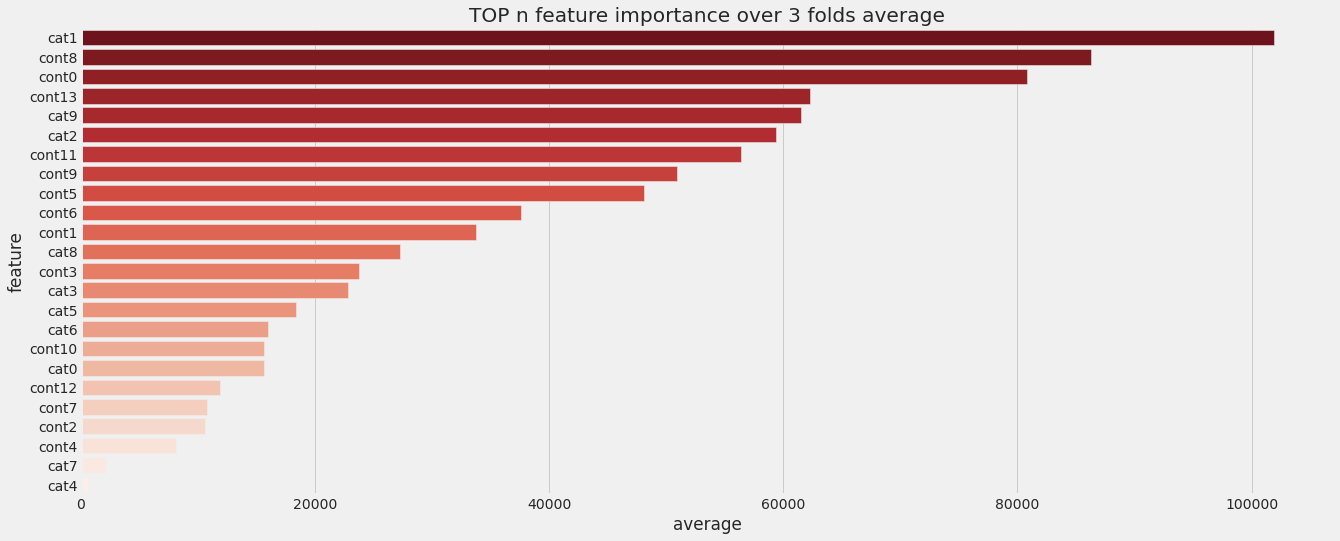

In [40]:
feature_importances_gain['average'] = feature_importances_gain[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
feature_importances_gain.to_csv('feature_importances.csv')

plt.figure(figsize=(20, 8))
sns.barplot(data=feature_importances_gain.sort_values(by='average', ascending=False).head(100),palette='Reds_r',  x='average', y='feature');
plt.title('TOP n feature importance over {} folds average'.format(folds.n_splits));